# **Group members:**

*   Daniel Abidemi Ajisafe
*   Oluwabukola Grace Adegboro
*   Carole Fosso
*   Hussam Eldeen Mohamed









In [0]:
%matplotlib inline

We use the same data as in the paper which is available for free here <https://urbansounddataset.weebly.com/>_ and contains 10 audio classes with over 8000 audio samples! 

In [0]:
!wget https://goo.gl/8hY5ER # When downloaded to google drive, it stays there for a maximum of 8 hours.
!tar -xf 8hY5ER # unzips the file. 

--2019-12-16 11:54:00--  https://goo.gl/8hY5ER
Resolving goo.gl (goo.gl)... 74.125.142.139, 74.125.142.100, 74.125.142.113, ...
Connecting to goo.gl (goo.gl)|74.125.142.139|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz [following]
--2019-12-16 11:54:01--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.95.95
Connecting to zenodo.org (zenodo.org)|188.184.95.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘8hY5ER’

8hY5ER              100%[===================>]   5.61G  9.56MB/s    in 6m 22s  

2019-12-16 12:00:23 (15.1 MB/s) - ‘8hY5ER’ saved [6023741708/6023741708]



In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchaudio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #sanity check
print(device)

cuda
cuda


In [0]:
class AudioDataset(Dataset):
    """
    A rapper class for the UrbanSound8K dataset.
    """

    def __init__(self, file_path, audio_paths, folds):
        """
        Args:data
            file_path(string): path to the audio csv file
            root_dir(string): directory with all the audio folds
            folds: integer corresponding to audio fold number or list of fold number if more than one fold is needed
        """
        self.audio_file = pd.read_csv(file_path)
        self.folds = folds
        self.audio_paths = glob.glob(audio_paths + '/*' + str(self.folds) + '/*')
    
    

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        
        audio_path = self.audio_paths[idx]
        audio, rate = torchaudio.load(audio_path, normalization=True)
        audio = audio.mean(0, keepdim=True)
        c, n = audio.shape
        zero_need = 160000 - n
        audio_new = F.pad(audio, (zero_need //2, zero_need //2), 'constant', 0)
        audio_new = audio_new[:,::5]
        
        #Getting the corresponding label
        audio_name = audio_path.split(sep='/')[-1]
        labels = self.audio_file.loc[self.audio_file.slice_file_name == audio_name].iloc[0,-2]
        
        return audio_new, labels


In [0]:
def init_weights(m):
   if type(m) == nn.Conv1d or type(m) == nn.Linear: #This initializes all layers that we have at the start.
       nn.init.xavier_uniform_(m.weight.data)


class M5(nn.Module):                           # this is m5 architecture
    def __init__(self):
        super(M5, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, 80, 4)  #(in, out, filter size, stride)
        self.bn1 = nn.BatchNorm1d(128)         #normalize 
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)    #by default,the stride is 1 if it is not specified here.
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        
        self.avgPool = nn.AdaptiveAvgPool1d(1) #insteads of using nn.AvgPool1d(30) (where I need to manually check the dimension that comes in). I use adaptive n flatten
        #the advantage of adaptiveavgpool is that it manually adjust to avoid dimension issues
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, 10)          # this is the output layer.
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        # print(x.shape)
        x = self.avgPool(x)
        x = self.flatten(x)  # replaces permute(0,2,1) with flatten
        x = self.fc1(x)       #output layer ([n,1, 10] i.e 10 probs. for each audio files) 
        return x # we didnt use softmax here becuz we already have that in cross entropy

class M3(nn.Module):                           # this is m3 architecture
    def __init__(self):
        super(M3, self).__init__()
        self.conv1 = nn.Conv1d(1, 256, 80, 4)  #(in, out, filter size, stride).
        self.bn1 = nn.BatchNorm1d(256)         # this is used to normalize.
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(256, 256, 3)    # by default,the stride is 1 if it is not specified here.
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(4)

        self.avgPool = nn.AdaptiveAvgPool1d(1) # 
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 10)          # this is the output layer.
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.avgPool(x)
        x = self.flatten(x) 
        x = self.fc1(x)                        # this is the output layer, [n,1, 10] i.e 10 probs for each audio files 
        return x

class M11(nn.Module):                          # this is m11 architecture
    def __init__(self):
        super(M11, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 80, 4)   #(in, out, filter size, stride)
        self.bn1 = nn.BatchNorm1d(64)          # this is used to normalize 
        self.pool1 = nn.MaxPool1d(4)

        self.conv2 = nn.Conv1d(64, 64, 3)      # by default, the stride is 1 if it is not specified here.
        self.bn2 = nn.BatchNorm1d(64)
        self.conv2b = nn.Conv1d(64, 64, 3)     # by default, the stride is 1 if it is not specified here.
        self.bn2b = nn.BatchNorm1d(64)
    
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(64, 128, 3)
        self.bn3 = nn.BatchNorm1d(128)
        self.conv3b = nn.Conv1d(128, 128, 3)
        self.bn3b = nn.BatchNorm1d(128)


        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(128, 256, 3)
        self.bn4 = nn.BatchNorm1d(256)
        self.conv4b = nn.Conv1d(256, 256, 3)
        self.bn4b = nn.BatchNorm1d(256)
        self.conv4c = nn.Conv1d(256, 256, 3)
        self.bn4c = nn.BatchNorm1d(256)

        self.pool4 = nn.MaxPool1d(4)
        self.conv5 = nn.Conv1d(256, 512, 3)
        self.bn5 = nn.BatchNorm1d(512)
        self.conv5b = nn.Conv1d(512, 512, 3)
        self.bn5b = nn.BatchNorm1d(512)

        # self.avgPool = nn.AvgPool1d(25)      #replaced with ADaptive + flatten
        self.avgPool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, 10)          # this is the output layer.
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.conv2b(x)
        x = F.relu(self.bn2b(x))

        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv3b(x)
        x = F.relu(self.bn3b(x))

        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.conv4b(x)
        x = F.relu(self.bn4b(x))
        x = self.conv4c(x)
        x = F.relu(self.bn4c(x))

        x = self.pool4(x)
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.conv5b(x)
        x = F.relu(self.bn5b(x))

        x = self.avgPool(x)
        x = self.flatten(x) 
        x = self.fc1(x)                        # this is the output layer. [n,1, 10] i.e 10 probs for each audio files 
        return x

class M18(nn.Module):                          # this is m18 architecture
    def __init__(self):
        super(M18, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 80, 4)   # (in, out, filter size, stride)
        self.bn1 = nn.BatchNorm1d(64)          # this is used to normalize. 
        self.pool1 = nn.MaxPool1d(4)

        self.conv2 = nn.Conv1d(64, 64, 3)      # by default, the stride is 1 if it is not specified here.
        self.bn2 = nn.BatchNorm1d(64)
        self.conv2b = nn.Conv1d(64, 64, 3)     # by default, the stride is 1 if it is not specified here.
        self.bn2b = nn.BatchNorm1d(64)
        self.conv2c = nn.Conv1d(64, 64, 3)     
        self.bn2c = nn.BatchNorm1d(64)
        self.conv2d = nn.Conv1d(64, 64, 3)     
        self.bn2d = nn.BatchNorm1d(64)
    
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(64, 128, 3)
        self.bn3 = nn.BatchNorm1d(128)
        self.conv3b = nn.Conv1d(128, 128, 3)
        self.bn3b = nn.BatchNorm1d(128)
        self.conv3c = nn.Conv1d(128, 128, 3)
        self.bn3c = nn.BatchNorm1d(128)
        self.conv3d = nn.Conv1d(128, 128, 3)
        self.bn3d = nn.BatchNorm1d(128)


        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(128, 256, 3)
        self.bn4 = nn.BatchNorm1d(256)
        self.conv4b = nn.Conv1d(256, 256, 3)
        self.bn4b = nn.BatchNorm1d(256)
        self.conv4c = nn.Conv1d(256, 256, 3)
        self.bn4c = nn.BatchNorm1d(256)
        self.conv4d = nn.Conv1d(256, 256, 3)
        self.bn4d = nn.BatchNorm1d(256)

        self.pool4 = nn.MaxPool1d(4)
        self.conv5 = nn.Conv1d(256, 512, 3)
        self.bn5 = nn.BatchNorm1d(512)
        self.conv5b = nn.Conv1d(512, 512, 3)
        self.bn5b = nn.BatchNorm1d(512)
        self.conv5c = nn.Conv1d(512, 512, 3)
        self.bn5c = nn.BatchNorm1d(512)
        self.conv5d = nn.Conv1d(512, 512, 3)
        self.bn5d = nn.BatchNorm1d(512)
        
        self.avgPool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, 10)           # this is the output layer.
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.conv2b(x)
        x = F.relu(self.bn2b(x))
        x = self.conv2c(x)
        x = F.relu(self.bn2c(x))
        x = self.conv2d(x)
        x = F.relu(self.bn2d(x))

        x = self.pool2(x)
      
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv3b(x)
        x = F.relu(self.bn3b(x))
        x = self.conv3c(x)
        x = F.relu(self.bn3c(x))
        x = self.conv3d(x)
        x = F.relu(self.bn3d(x))

        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.conv4b(x)
        x = F.relu(self.bn4b(x))
        x = self.conv4c(x)
        x = F.relu(self.bn4c(x))
        x = self.conv4d(x)
        x = F.relu(self.bn4d(x))

        x = self.pool4(x)
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.conv5b(x)
        x = F.relu(self.bn5b(x))
        x = self.conv5c(x)
        x = F.relu(self.bn5c(x))
        x = self.conv5d(x)
        x = F.relu(self.bn5d(x))

        x = self.avgPool(x)
        x = self.flatten(x)
        x = self.fc1(x)                      # this is the output layer. [n,1, 10] i.e 10 probs for each audio files
        return x

def res_upsamp(A,m,n):
  upsample = nn.Upsample(size=(m,n), mode='nearest')
  A = torch.unsqueeze(A, 0)
  A = upsample(A)
  A = A.view(-1,m,n)
  return A

class M34(nn.Module):                          # This is m34 architecture. It is actually the implementation of Resnet34.
    def __init__(self):
        super(M34, self).__init__()
        self.conv1 = nn.Conv1d(1, 48, 80, 4)   # (in, out, filter size, stride)
        self.bn1 = nn.BatchNorm1d(48)          # this is used to normalize. 
        self.pool1 = nn.MaxPool1d(4)

        #upsample residual, pad X via the convolutions

        #X3
        self.conv2a = nn.Conv1d(48, 48, 3, padding = 1)   # by default, the stride is 1 if it is not specified here.
        self.bn2a = nn.BatchNorm1d(48)
        self.conv2a2 = nn.Conv1d(48, 48, 3, padding = 1)  
        self.bn2a2 = nn.BatchNorm1d(48)
        self.bn2a3 = nn.BatchNorm1d(48)
        self.pool2 = nn.MaxPool1d(4)

        self.conv2b = nn.Conv1d(48, 48, 3, padding = 1)   
        self.bn2b = nn.BatchNorm1d(48)
        self.conv2b2 = nn.Conv1d(48, 48, 3, padding=1)    
        self.bn2b2 = nn.BatchNorm1d(48)
        self.bn2b3 = nn.BatchNorm1d(48)

        self.conv2c = nn.Conv1d(48, 48, 3, padding=1)     
        self.bn2c = nn.BatchNorm1d(48)
        self.conv2c2 = nn.Conv1d(48, 48, 3, padding=1)   
        self.bn2c2 = nn.BatchNorm1d(48)
        self.bn2c3 = nn.BatchNorm1d(48)

        #X4
        self.conv3a = nn.Conv1d(48, 96, 3)     # upsampling on the 1st two convulutions, padding on the rest.
        self.bn3a = nn.BatchNorm1d(96)
        self.conv3a2 = nn.Conv1d(96, 96,3)     # by default, the stride is 1 if it is not specified here.
        self.bn3a2 = nn.BatchNorm1d(96)
        self.bn3a3 = nn.BatchNorm1d(96)
        self.pool3 = nn.MaxPool1d(4)

        self.conv3b = nn.Conv1d(96, 96, 3, padding=1)  
        self.bn3b = nn.BatchNorm1d(96)
        self.conv3b2 = nn.Conv1d(96, 96, 3, padding=1)    
        self.bn3b2 = nn.BatchNorm1d(96)
        self.bn3b3 = nn.BatchNorm1d(96)

        self.conv3c = nn.Conv1d(96, 96, 3, padding=1)    
        self.bn3c = nn.BatchNorm1d(96)
        self.conv3c2 = nn.Conv1d(96, 96, 3, padding=1)   
        self.bn3c2 = nn.BatchNorm1d(96)
        self.bn3c3 = nn.BatchNorm1d(96)

        self.conv3d = nn.Conv1d(96, 96, 3, padding=1)   
        self.bn3d = nn.BatchNorm1d(96)
        self.conv3d2 = nn.Conv1d(96, 96, 3, padding=1)  
        self.bn3d2 = nn.BatchNorm1d(96)
        self.bn3d3 = nn.BatchNorm1d(96)
        
        #X6
        self.conv4a = nn.Conv1d(96, 192, 3)    # by default, the stride is 1 if it is not specified here.
        self.bn4a = nn.BatchNorm1d(192)
        self.conv4a2 = nn.Conv1d(192, 192, 3) 
        self.bn4a2 = nn.BatchNorm1d(192)
        self.bn4a3 = nn.BatchNorm1d(192)

        self.conv4b = nn.Conv1d(192, 192, 3, padding=1) 
        self.bn4b = nn.BatchNorm1d(192)
        self.conv4b2 = nn.Conv1d(192, 192, 3, padding=1) 
        self.bn4b2 = nn.BatchNorm1d(192)
        self.bn4b3 = nn.BatchNorm1d(192)

        self.conv4c = nn.Conv1d(192, 192, 3, padding=1)  
        self.bn4c = nn.BatchNorm1d(192)
        self.conv4c2 = nn.Conv1d(192, 192, 3, padding=1)
        self.bn4c2 = nn.BatchNorm1d(192)
        self.bn4c3 = nn.BatchNorm1d(192)

        self.conv4d = nn.Conv1d(192, 192, 3, padding=1)
        self.bn4d = nn.BatchNorm1d(192)
        self.conv4d2 = nn.Conv1d(192, 192, 3, padding=1)
        self.bn4d2 = nn.BatchNorm1d(192)
        self.bn4d3 = nn.BatchNorm1d(192)
        self.pool4 = nn.MaxPool1d(4)

        self.conv4e = nn.Conv1d(192, 192, 3, padding=1) 
        self.bn4e = nn.BatchNorm1d(192)
        self.conv4e2 = nn.Conv1d(192, 192, 3, padding=1) 
        self.bn4e2 = nn.BatchNorm1d(192)
        self.bn4e3 = nn.BatchNorm1d(192)

        self.conv4f = nn.Conv1d(192, 192, 3, padding=1) 
        self.bn4f = nn.BatchNorm1d(192)
        self.conv4f2 = nn.Conv1d(192, 192, 3, padding=1) 
        self.bn4f2 = nn.BatchNorm1d(192)
        self.bn4f3 = nn.BatchNorm1d(192)
        
        #X3
        self.conv5a = nn.Conv1d(192, 384, 3) 
        self.bn5a = nn.BatchNorm1d(384)
        self.conv5a2 = nn.Conv1d(384, 384, 3) 
        self.bn5a2 = nn.BatchNorm1d(384)
        self.bn5a3 = nn.BatchNorm1d(384)

        self.conv5b = nn.Conv1d(384, 384, 3, padding=1)  
        self.bn5b = nn.BatchNorm1d(384)
        self.conv5b2 = nn.Conv1d(384, 384, 3, padding=1) 
        self.bn5b2 = nn.BatchNorm1d(384)
        self.bn5b3 = nn.BatchNorm1d(384)

        self.conv5c = nn.Conv1d(384, 384, 3, padding=1)  
        self.bn5c = nn.BatchNorm1d(384)
        self.conv5c2 = nn.Conv1d(384, 384, 3, padding=1) 
        self.bn5c2 = nn.BatchNorm1d(384)
        self.bn5c3 = nn.BatchNorm1d(384)
        
        self.avgPool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(384, 10)         # this is the output layer.
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)


        #X3
        residual = x                          # update once for the 3 blocks
        x = F.relu(self.bn2a(self.conv2a(x)))
        # x += residual
        x = self.conv2a2(x)
        x = self.bn2a2(x)
        #add, skip connection
        
        x += residual
        x = F.relu(self.bn2a3(x))

        x = self.conv2b(x)
        x = F.relu(self.bn2b(x))
        x = self.conv2b2(x)
        x = self.bn2b2(x)
        #add
        x += residual
        x = F.relu(self.bn2b3(x))

        x = self.conv2c(x)
        x = F.relu(self.bn2c(x))
        x = self.conv2c2(x)
        x = self.bn2c2(x)
        #add
        x += residual
        x = F.relu(self.bn2c3(x))

        x = self.pool2(x)
        
        #X4
        residual = x                         # update once for the 4 blocks
        x = F.relu(self.bn3a(self.conv3a(x)))
        x = self.bn3a2(self.conv3a2(x))
        #add, skip connection
        residual = res_upsamp(residual,x.shape[1],x.shape[2])  # we pad at the beginning of every block which is after the first two(2) convolutions.
        x += residual
        x = F.relu(self.bn3a3(x))

  
        x = self.conv3b(x)
        x = F.relu(self.bn3b(x))
        x = self.conv3b2(x)
        x = self.bn3b2(x)
        #add, skip connection
        x += residual
        x = F.relu(self.bn3b3(x))

        x = self.conv3c(x)
        x = F.relu(self.bn3c(x))
        x = self.conv3c2(x)
        x = self.bn3c2(x)
        #add, skip connection
        x += residual
        x = F.relu(self.bn3c3(x))

        x = self.conv3d(x)
        x = F.relu(self.bn3d(x))
        x = self.conv3d2(x)
        x = self.bn3d2(x)
        #add, skip connection
        x += residual
        x = F.relu(self.bn3d3(x))
        x = self.pool3(x)

        #x6
        residual = x                    # update once for the 6 blocks
        x = self.conv4a(x)
        x = F.relu(self.bn4a(x))
        x = self.conv4a2(x)
        x = self.bn4a2(x)
        #add, skip connection

        residual = res_upsamp(residual,x.shape[1],x.shape[2]) # we pad at the beginning of every block which is after the first two(2) convolutions.

        x += residual
        x = F.relu(self.bn4a3(x))

        x = self.conv4b(x)
        x = F.relu(self.bn4b(x))
        x = self.conv4b2(x)
        x = self.bn4b2(x)
        #add, skip connection
        x += residual
        x = F.relu(self.bn4b3(x))

        x = self.conv4c(x)
        x = F.relu(self.bn4c(x))
        x = self.conv4c2(x)
        x = self.bn4c2(x)
        #add, skip connection
        x += residual
        x = F.relu(self.bn4c3(x))

        x = self.conv4d(x)
        x = F.relu(self.bn4d(x))
        x = self.conv4d2(x)
        x = self.bn4d2(x)
        #add, skip connection
        x += residual
        x = F.relu(self.bn4d3(x))

        x = self.conv4e(x)
        x = F.relu(self.bn4e(x))
        x = self.conv4e2(x)
        x = self.bn4e2(x)
        #add, skip connection
        x += residual
        x = F.relu(self.bn4e3(x))

        x = self.conv4f(x)
        x = F.relu(self.bn4f(x))
        x = self.conv4f2(x)
        x = self.bn4f2(x)
        #add, skip connection
        x += residual
        x = F.relu(self.bn4f3(x))
        x = self.pool4(x)

        #X3
        residual = x                           # update once for the 3 blocks
        x = self.conv5a(x)
        x = F.relu(self.bn5a(x))
        x = self.conv5a2(x)
        x = self.bn5a2(x)
        #add, skip connection
        residual = res_upsamp(residual,x.shape[1],x.shape[2])# we pad at the beginning of every block which is after the first two(2) convolutions.
        x += residual
        x = F.relu(self.bn5a3(x))

        x = self.conv5b(x)
        x = F.relu(self.bn5b(x))
        x = self.conv5b2(x)
        x = self.bn5b2(x)
        #add, skip connection
        x += residual
        x = F.relu(self.bn5b3(x))

        x = self.conv5c(x)
        x = F.relu(self.bn5c(x))
        x = self.conv5c2(x)
        x = self.bn5c2(x)
        #add, skip connection
        x += residual
        x = F.relu(self.bn5c3(x))


      
        x = self.avgPool(x)
        x = self.flatten(x) 
        x = self.fc1(x)                   # this is the output layer, [n,1, 10] i.e 10 probs for each audio files 
        return x


In [0]:
# function to count model paramaters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
# Initialize the model
model1 = M3()
# Print number of parameters
print('number of parameters for M3:', count_parameters(model1))

model2 = M5()
# Print number of parameters
print('number of parameters for M5:', count_parameters(model2))

model3 = M11()
# Print number of parameters
print('number of parameters for M11:', count_parameters(model3))

model4 = M18()
# Print number of parameters
print('number of parameters for M18:', count_parameters(model4))

model5 = M34()
# Print number of parameters
print('number of parameters for M34:', count_parameters(model5))

number of parameters for M3: 221194
number of parameters for M5: 559114
number of parameters for M11: 1786442
number of parameters for M18: 3683786
number of parameters for M34: 3984154
number of parameters for M3: 221194
number of parameters for M5: 559114
number of parameters for M11: 1786442
number of parameters for M18: 3683786
number of parameters for M34: 3984154


We use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training.




Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps.




In [0]:
def train(model, epoch):
    model.train()
    train_avg_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss() 

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        #data = data.requires_grad()
        output = model(data)
        #removed permute totally and used output directly instead of output[0]
        loss = criterion(output, target) # the loss functions expects a batchSize x 10 input
        loss.backward()
        optimizer.step()
        train_avg_loss += loss.item()
        # compute accuracy 
        correct += accuracy(output, target)[0].item() * data.size(0) / 100
    

    acc = correct / len(train_loader.dataset) * 100
    ls = train_avg_loss/ len(train_loader)
    print('Train accuracy: {:.2f}%'.format(acc)) # this prints the accuracy at the end of an epoch.
    print('Train Loss: {}'.format(ls))


    return acc,ls
            

In [0]:
def test(model, epoch):
    test_avg_loss = 0
    model.eval() #turns off dropout and batchnorm during test time
    correct = 0
    correct2 = 0
    criterion = nn.CrossEntropyLoss() 
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        pred = output.max(dim=1)[1]         # this gets the index of the max log-probability.
        correct += pred.eq(target).cpu().sum().item()
        test_avg_loss += loss.item()
        correct2 += accuracy(output, target)[0].item() * data.size(0) / 100    
          
    acc = correct2 / len(test_loader.dataset) * 100
    ls = test_avg_loss / len(test_loader)
    print('Test accuracy: {:.2f}%'.format(acc))
    print('Test Loss: {}'.format(ls))

    return acc,ls


In [0]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




In [0]:
# Note: During the code implementation, we had an error saying 'CUDA out of memory'. 
# To solve this issue, there are three ways: 1) torch.cuda.empty_cache()  2) loss.item() should be used instead of only loss.  3) reduce the batchsize to 32.

In [1]:
# Initialize a store to keep the values gotten from each fold as a dictionary.
store = {}

In [ ]:
import numpy
import time
from sklearn.model_selection import LeaveOneOut,LeavePOut

networks      = [M3,M5,M11, M18, M34]
network_names = ['M3','M5','M11','M18','M34']
'''
Trick: so save significant runtime, we created two notebooks with different emails. Run one from M3 to M34 and the other one from M34 to M3 
simultaneously. Wait for them to meet somewhere at the middle and we can always copy out the store information in the prints anytime
'''
for net, network_name in zip(networks, network_names):
  model = net()
  model.apply(init_weights) #initialize the weights
  model.to(device) #put model to cuda

  optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001) # by default, l2 regularization is implemented in the weight decay.
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)
  
  # Cross validation using sklearn Leave one Out
  data = numpy.array([1,2,3,4,5,6,7,8,9,10])
  loocv = LeaveOneOut()
  loocv.get_n_splits(data)
  fold_number = 1
  for train_, test_ in loocv.split(data): 
    store_key = network_name + '-fold' + str(fold_number)
    #in case network breaks, just start from when you stopped
    if store_key in store:
      print('Skip training for', store_key)
      fold_number += 1
      continue

    #dataset
    train_set = AudioDataset(file_path, audio_paths, data[train_])
    test_set = AudioDataset(file_path, audio_paths, int(data[test_]))
    
    kwargs = {'num_workers': 8, 'pin_memory': True} if device == 'cuda' else {} #this is required for using the datasets on the gpu.
    #kwargs is an intelligent way of passing parameters to dataloader()
    #to speed up with parallel processing, we increase the no of workers

    #create dataloader
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = 128, shuffle = True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, **kwargs)

    log_interval = 20 #not useful since we are not using it in the train function to print output

    train_accs, train_losses = [],[]
    test_accs, test_losses = [],[]

    # a fold runs for 10 epochs
    for epoch in range(1, 10):
        start_time = time.time()
        # if epoch == 31:
        #     print("First round of training complete. Setting learn rate to 0.001.")
        scheduler.step()
        x,y = train(model, epoch)
        train_accs.append(x), train_losses.append(y)
        x,y = test(model, epoch)
        test_accs.append(x), test_losses.append(y)
        elapse = time.time() - start_time
        print('Epoch {} {:.1f} seconds - Model {}, fold {}'.format(epoch, elapse, network_name, fold_number))
    
    #store the info for each fold in case internet breaks
    store[store_key] = {
        'train_losses':train_losses,
        'test_losses':test_losses,
        'train_accs':train_accs,
        'test_accs':test_accs,
    }
    print('')
    print(store)
    print('\n\n', store_key, 'saved :D')
    fold_number += 1 #increase fold no for printing and storage 


In [0]:
#from train 1 ...to plot the graph
store1 = {'M3-fold1': {'train_losses': [2.0699746712394385, .......]}}

In [0]:
#from train 2 ... this was computed on another colab space.
store2 = {'M3-fold1': {'train_losses':  [2.0699746712394385, .......]}}

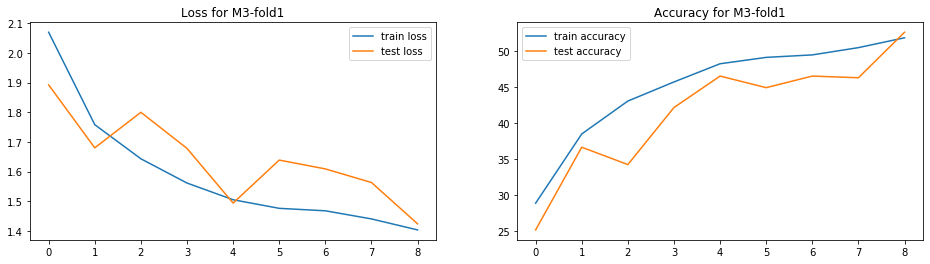

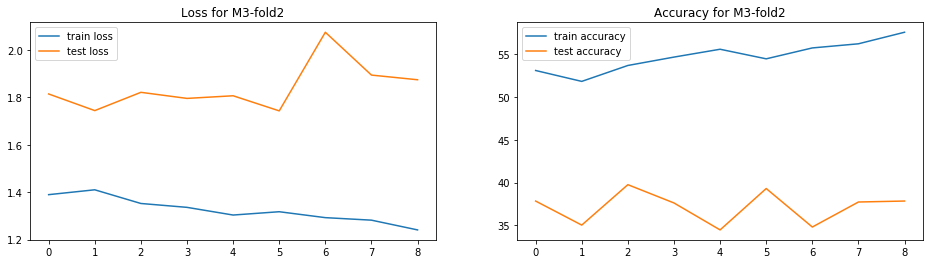

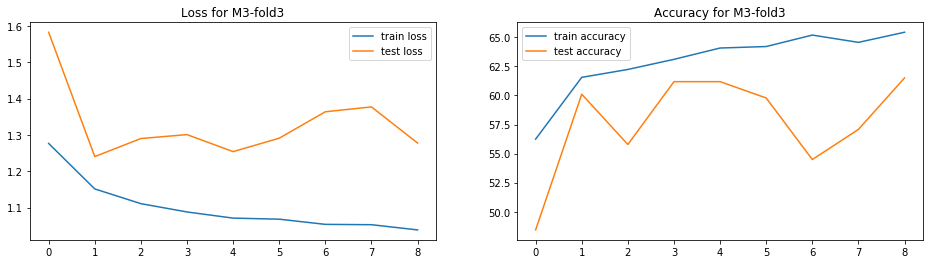

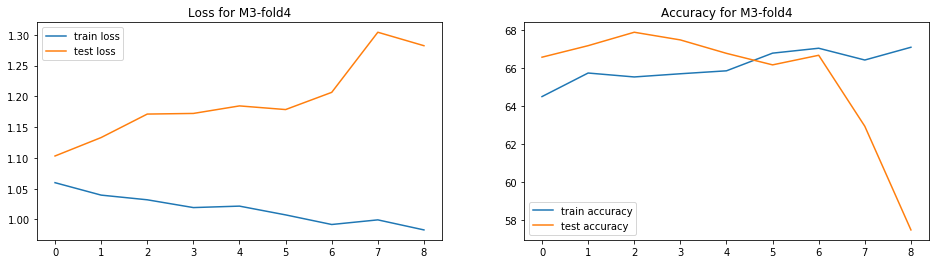

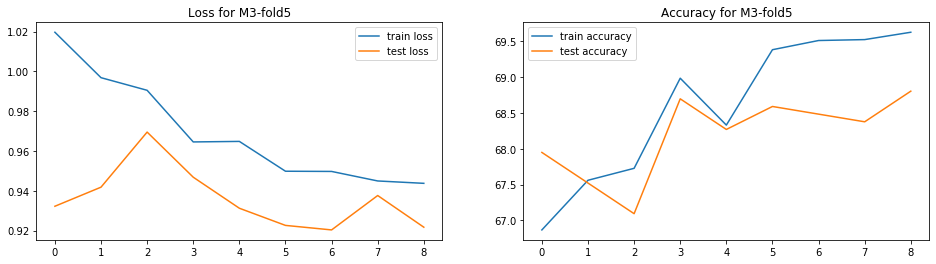

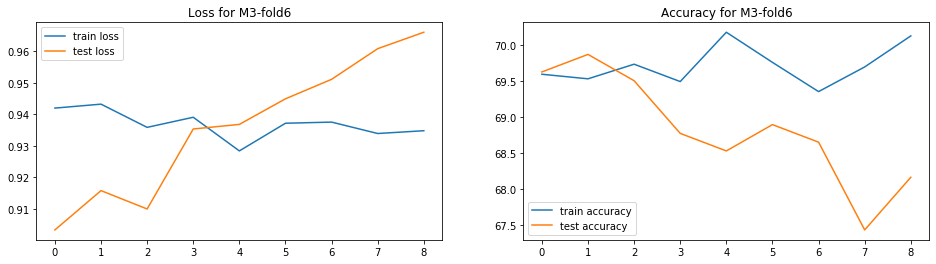

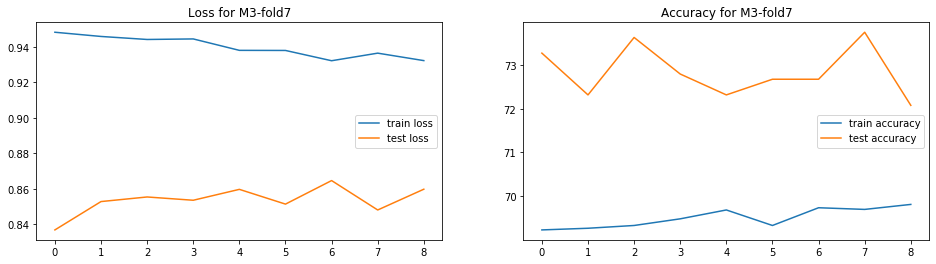

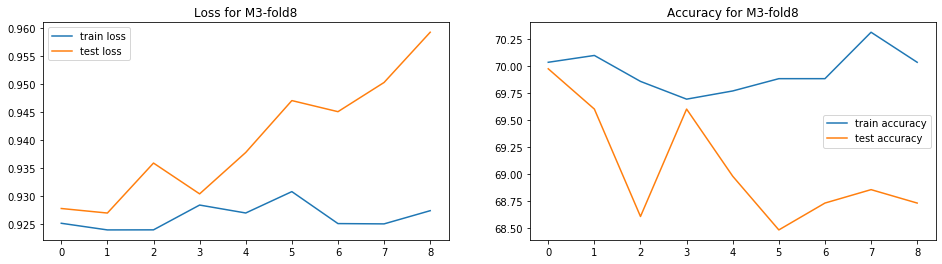

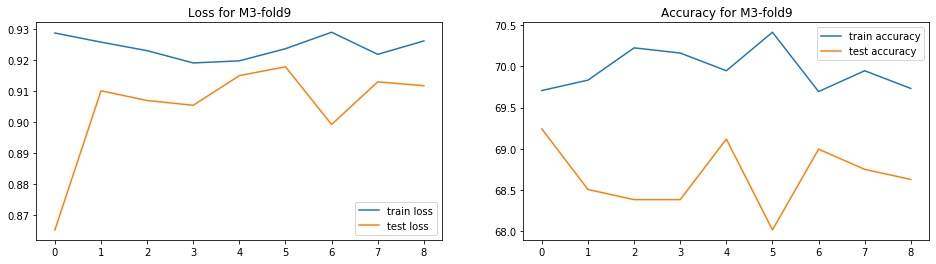

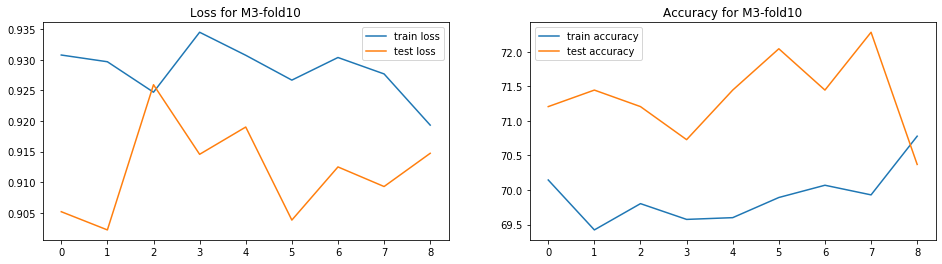

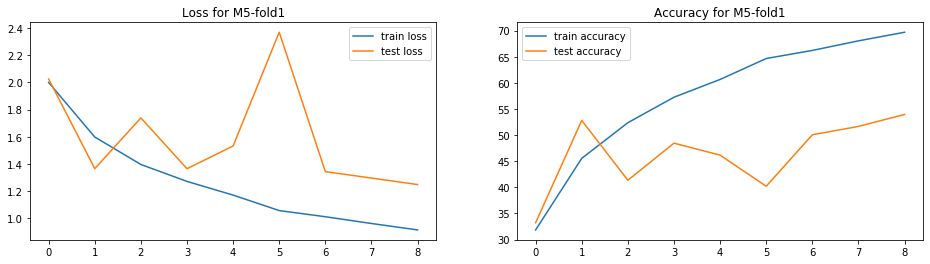

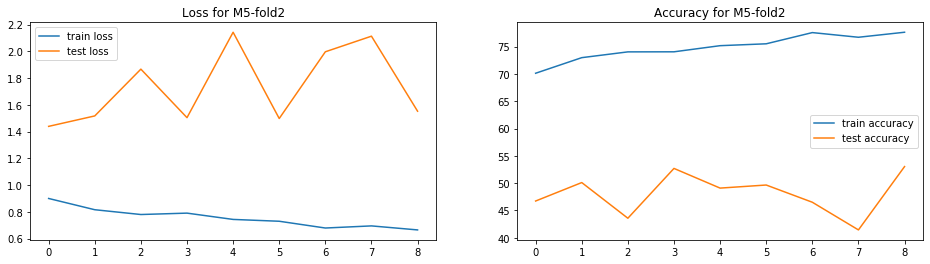

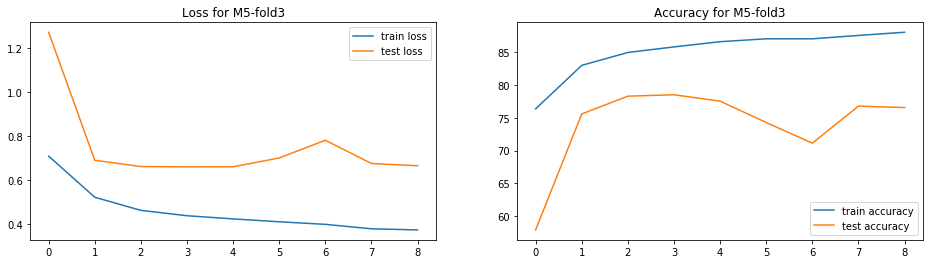

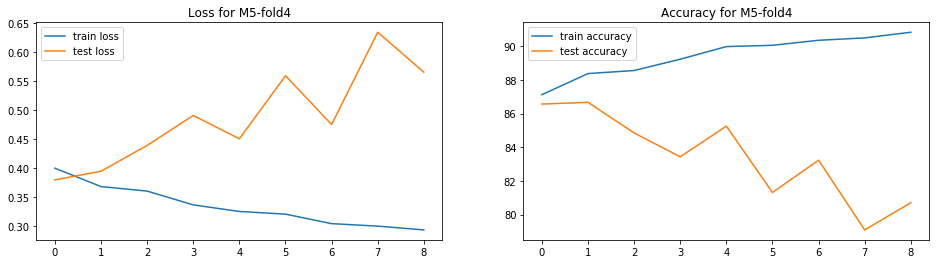

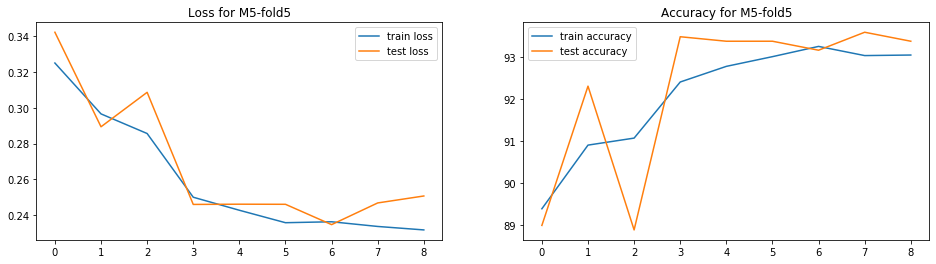

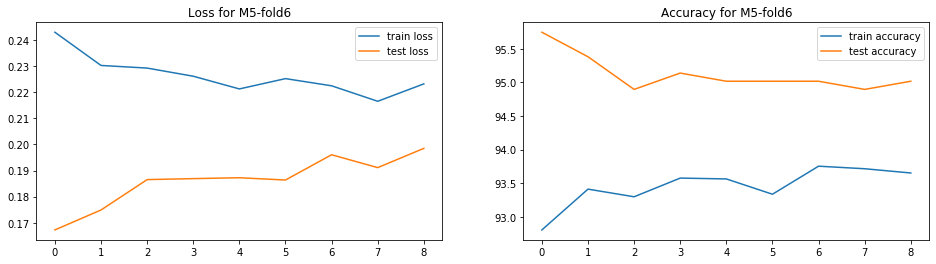

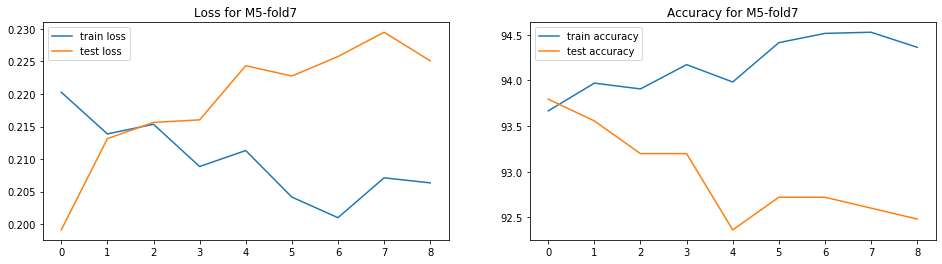

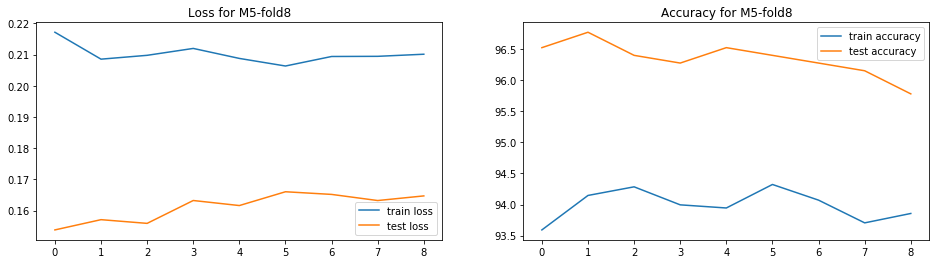

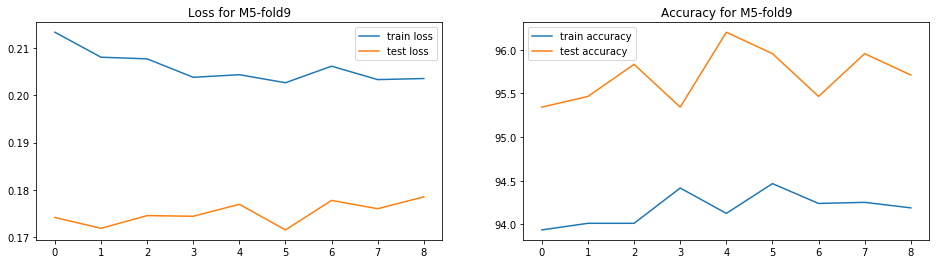

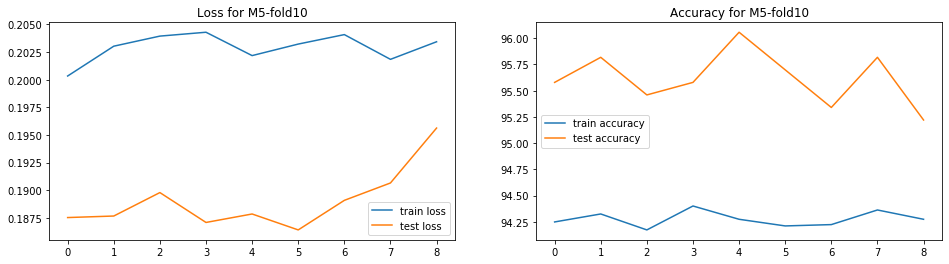

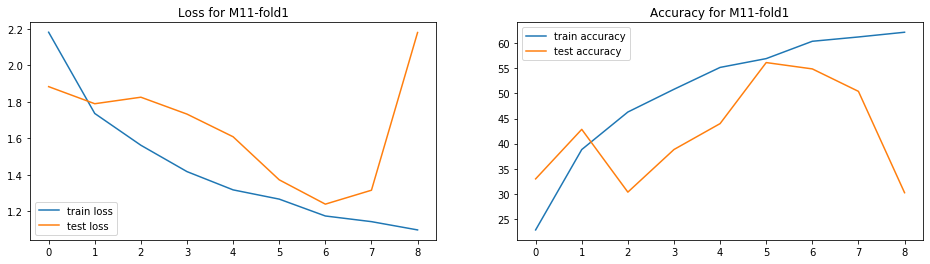

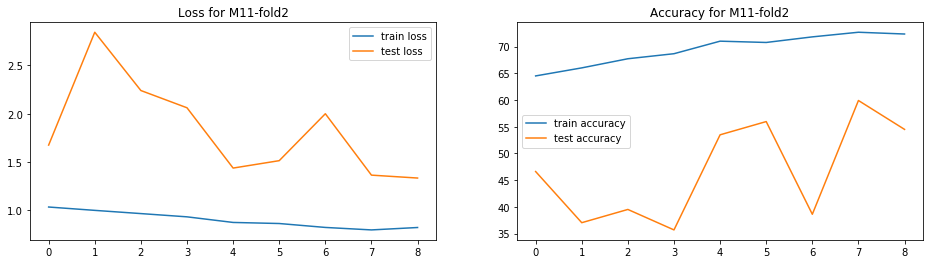

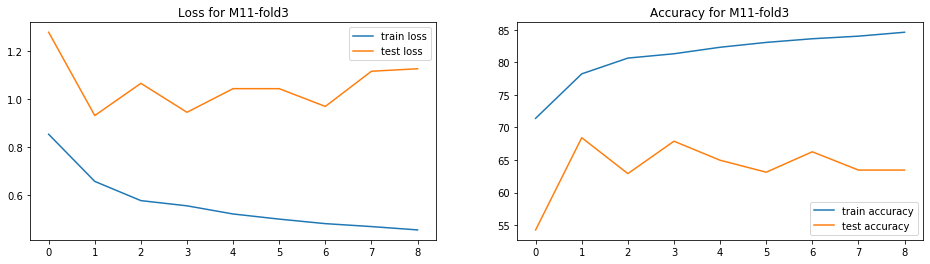

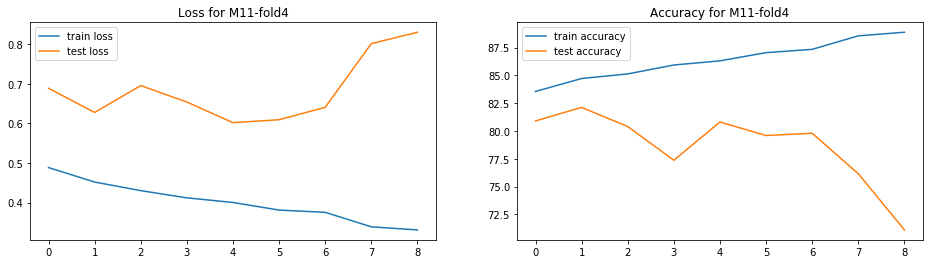

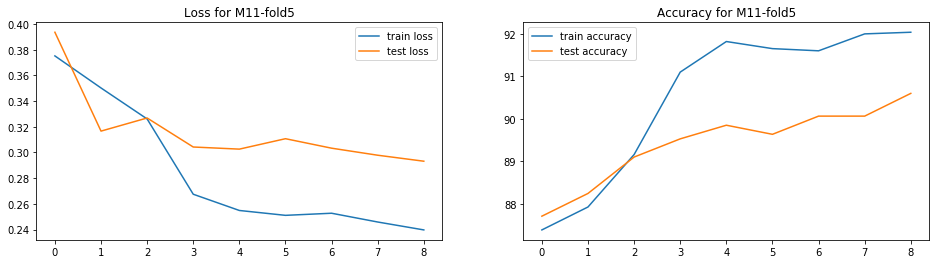

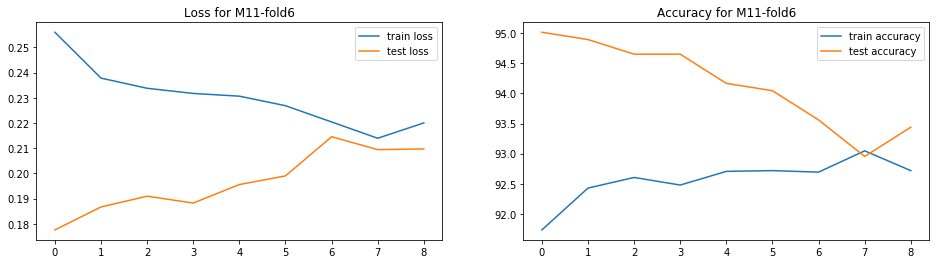

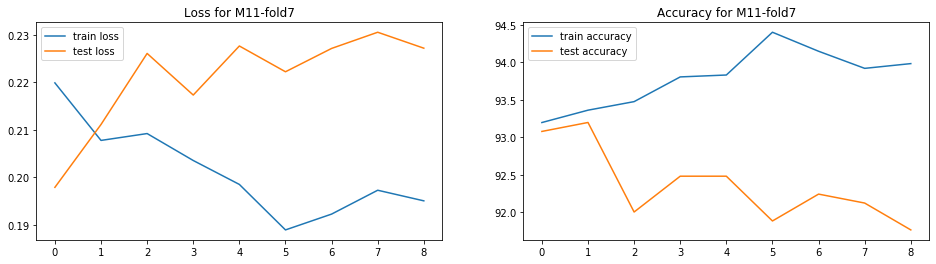

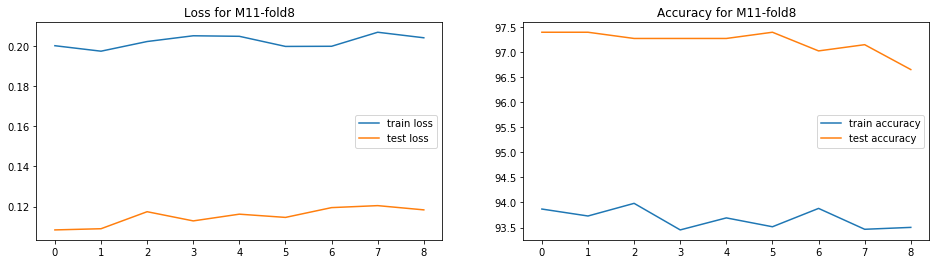

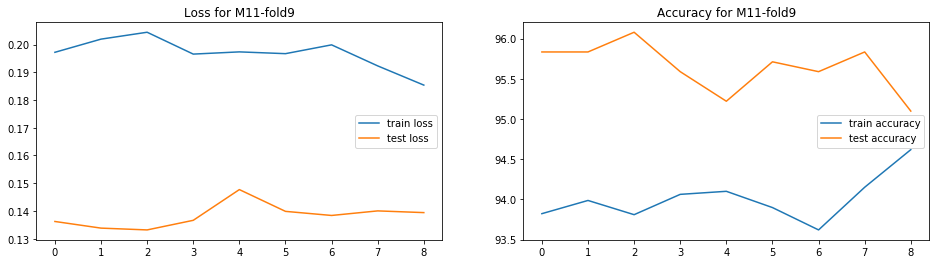

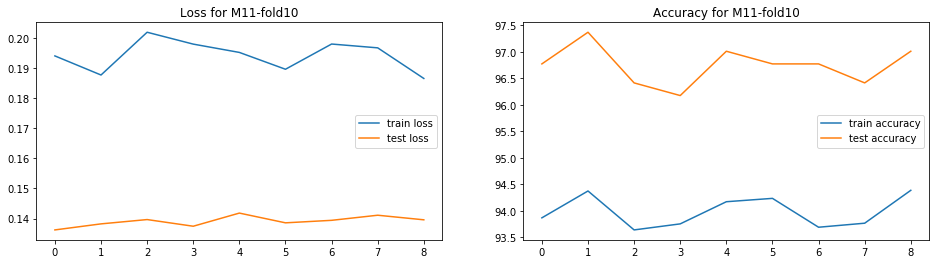

In [0]:
#plot from the store1
import matplotlib.pyplot as plt


for key, log in store1.items():
  if key == 'M18-fold1' or key == 'M18-fold2' or key == 'M18-fold3' or key == 'M18-fold4'  : # to remove the additional M..-folds that had been plotted already in the store2
    pass
  else:

    fig, ax = plt.subplots(1,2,figsize = (16,4))
    
    ax[0].set_title('Loss for '+key)
    ax[0].plot(log['train_losses'], label = 'train loss')
    ax[0].plot(log['test_losses'], label = 'test loss')
    ax[0].legend()

    ax[1].set_title('Accuracy for '+key)
    ax[1].plot(log['train_accs'], label = 'train accuracy')
    ax[1].plot(log['test_accs'], label = 'test accuracy')
    ax[1].legend()
    plt.show()

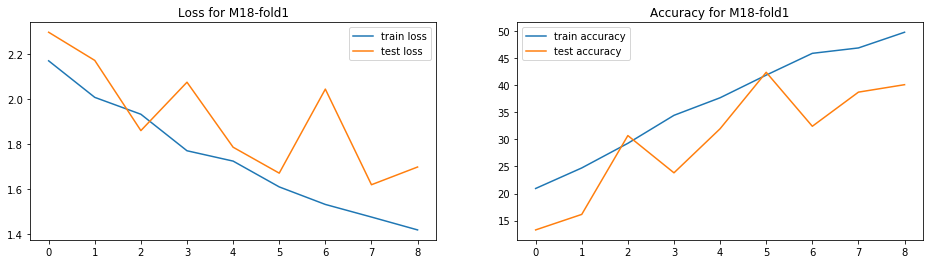

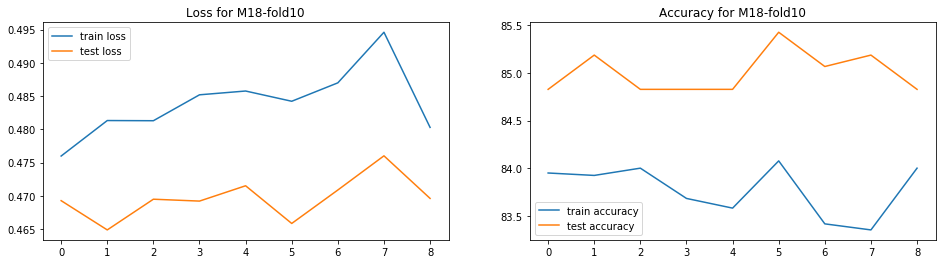

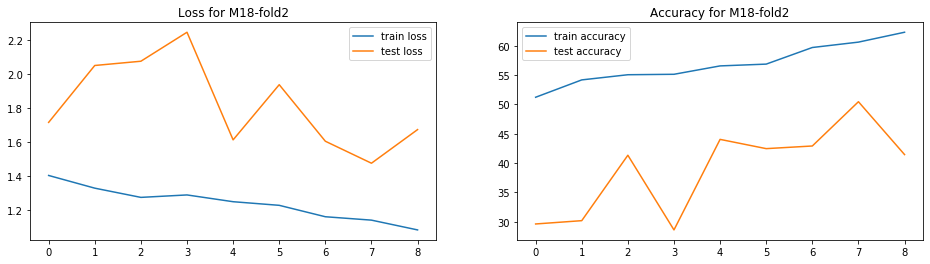

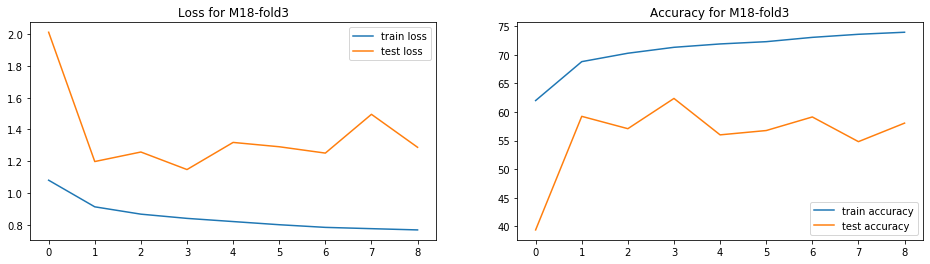

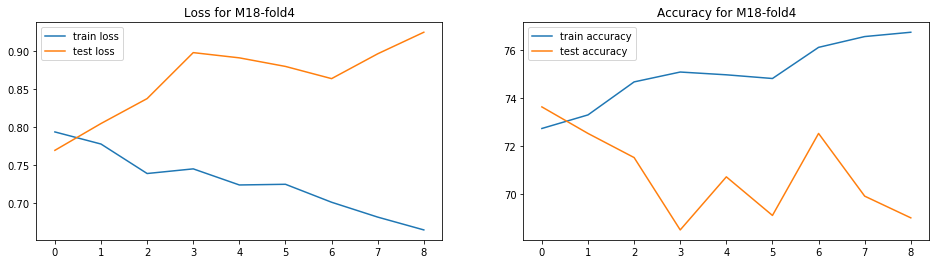

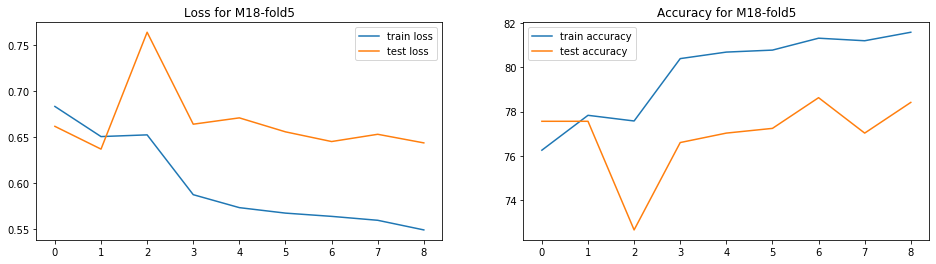

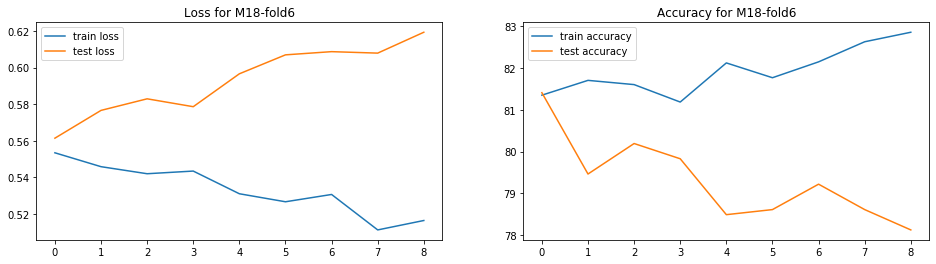

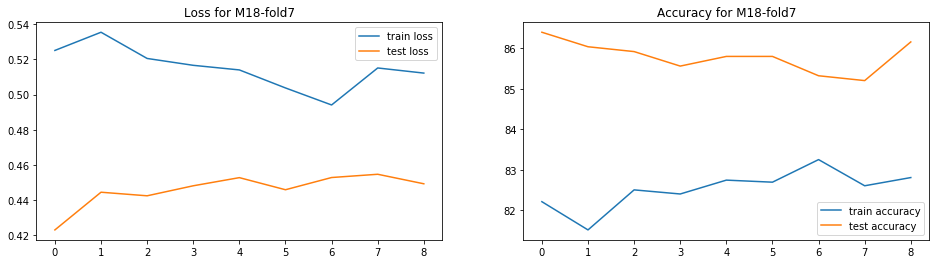

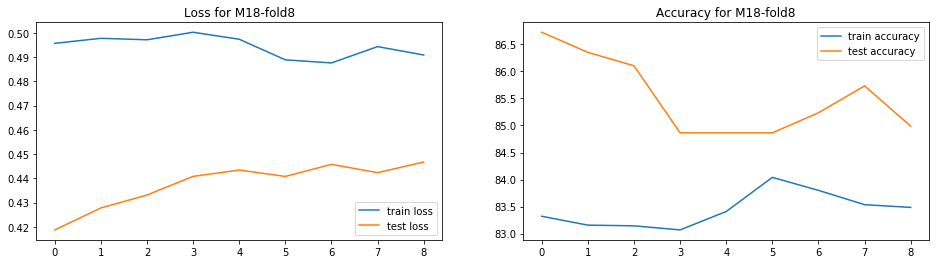

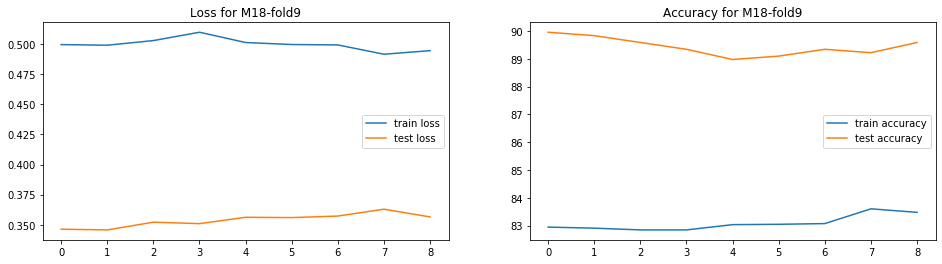

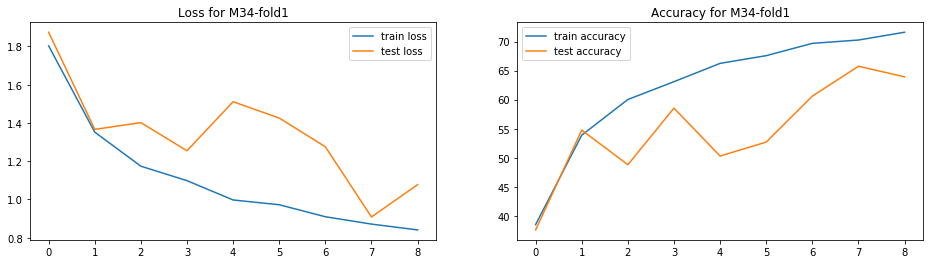

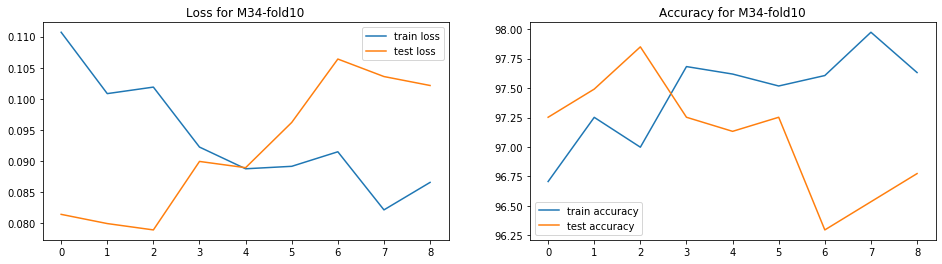

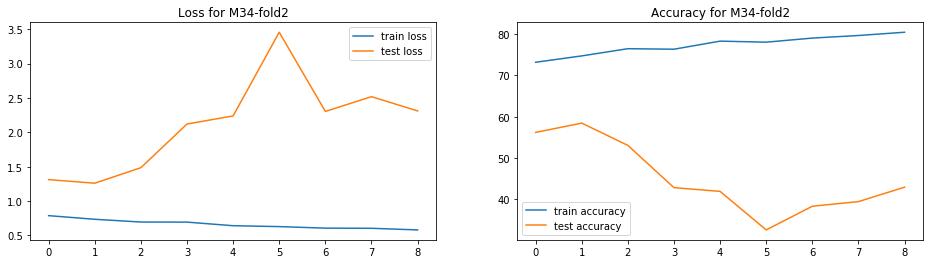

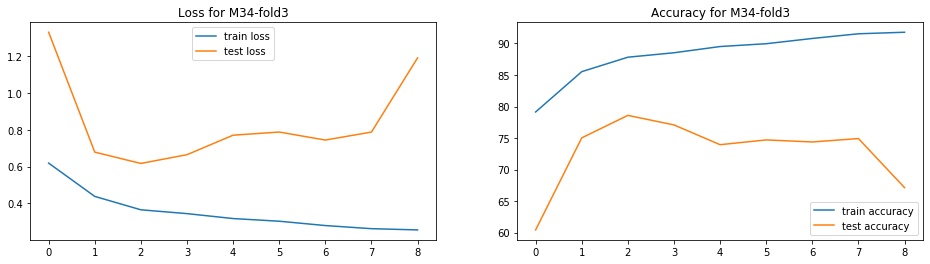

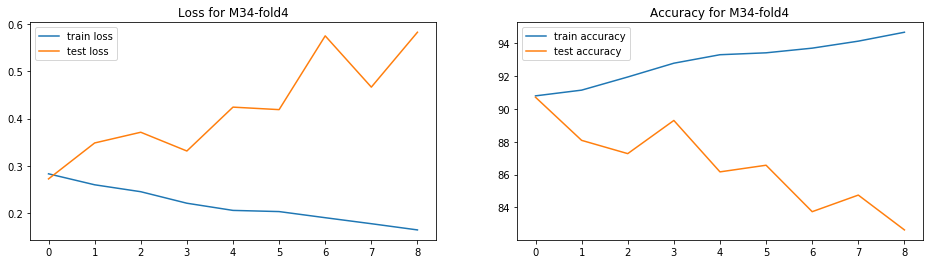

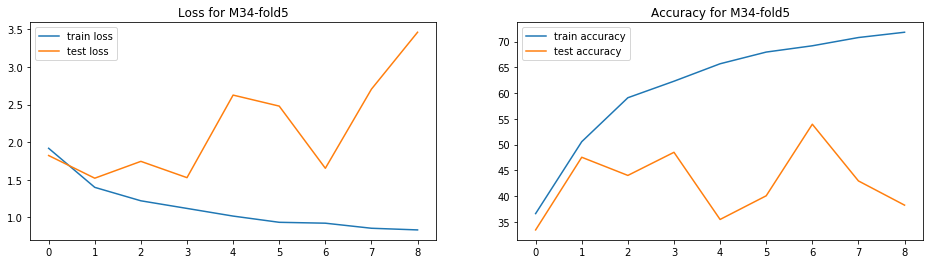

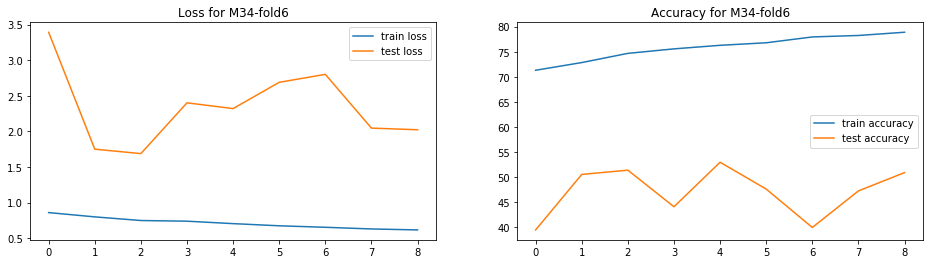

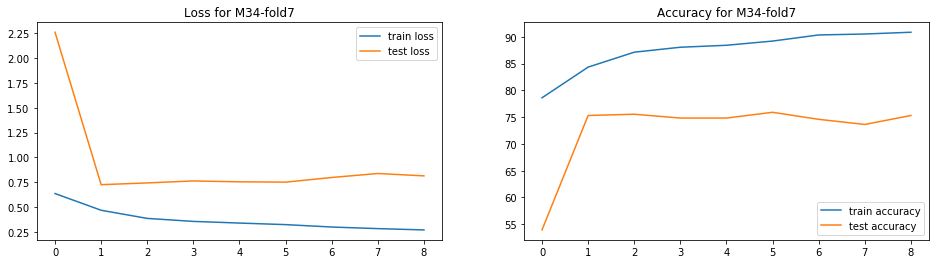

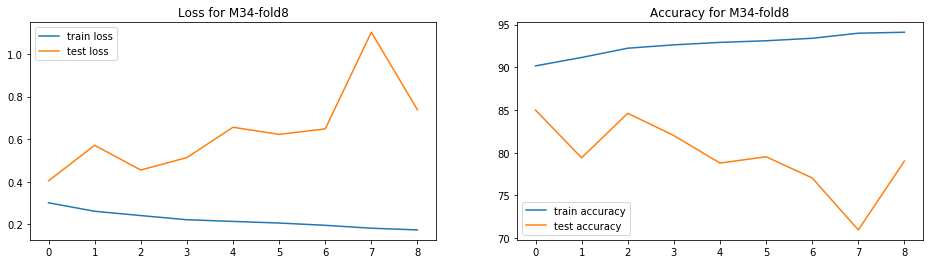

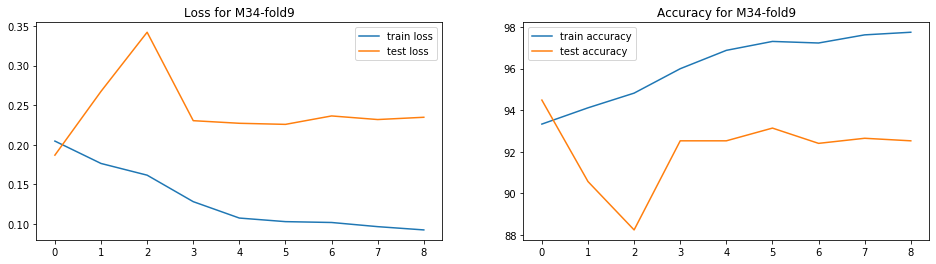

In [0]:
#plot from the store2

c = store2.items() # we plotted from M32 backwards in store2 so we had to sort it to plot from M18 to M34
d = sorted (c) 

for key, log in d:
  if key == 'M3-fold1' or key == 'M3-fold2' or key == 'M3-fold3' or key == 'M3-fold4' or key == 'M3-fold5' : # to remove the additional M..-folds that had been plotted already in the store1
    pass
  else:
    
    fig, ax = plt.subplots(1,2,figsize = (16,4))
    
    ax[0].set_title('Loss for '+key)
    ax[0].plot(log['train_losses'], label = 'train loss')
    ax[0].plot(log['test_losses'], label = 'test loss')
    ax[0].legend()

    ax[1].set_title('Accuracy for '+key)
    ax[1].plot(log['train_accs'], label = 'train accuracy')
    ax[1].plot(log['test_accs'], label = 'test accuracy')
    ax[1].legend()
    plt.show()